In [2]:
!pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 6.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=675165faece159e1e4f2bef0ed1e52744fc4fb12f0c90943bd20ec957a2e5ff2
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=ee4d4d393f693939baad9154cbc2e2fc40b790b3accac8c78f8808445f0addd2
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [7]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import segmentation_models_pytorch as smp
from sklearn.metrics import confusion_matrix
import cv2
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [8]:
# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [9]:
# Define paths (adjust according to dataset location on Kaggle)
image_dir = '/kaggle/input/deepglobe-land-cover-classification-dataset/train'
mask_dir = '/kaggle/input/deepglobe-land-cover-classification-dataset/train'

In [10]:
# Collect image and mask paths
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
mask_files = [f.replace('_sat.jpg', '_mask.png') for f in image_files]

image_paths = [os.path.join(image_dir, f) for f in image_files]
mask_paths = [os.path.join(mask_dir, f) for f in mask_files]

# Verify that all masks exist
for mp in mask_paths:
    if not os.path.exists(mp):
        raise FileNotFoundError(f"Mask {mp} not found")

# Split into train and validation
indices = np.random.permutation(len(image_paths))
split = int(0.8 * len(indices))
train_indices = indices[:split]
val_indices = indices[split:]

In [11]:
train_image_paths = [image_paths[i] for i in train_indices]
train_mask_paths = [mask_paths[i] for i in train_indices]
val_image_paths = [image_paths[i] for i in val_indices]
val_mask_paths = [mask_paths[i] for i in val_indices]

In [12]:
# Define color to class mapping (adjust according to dataset documentation)
colors = np.array([
    [0, 255, 255],   # Urban land (0)
    [255, 255, 0],    # Agriculture (1)
    [255, 0, 255],    # Rangeland (2)
    [0, 255, 0],      # Forest (3)
    [0, 0, 255],      # Water (4)
    [255, 255, 255],  # Barren (5)
    [0, 0, 0]         # Unknown (6)
], dtype=np.uint8)

# Define transforms
transform_train = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

transform_val = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

In [13]:
class DeepGlobeDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.colors = colors

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # ... (image loading code remains the same)
        image = cv2.cvtColor(cv2.imread(self.image_paths[idx]), cv2.COLOR_BGR2RGB)
        mask_rgb = cv2.cvtColor(cv2.imread(self.mask_paths[idx]), cv2.COLOR_BGR2RGB)
        
        # Convert mask to class indices
        h, w = mask_rgb.shape[:2]
        mask_flat = mask_rgb.reshape(-1, 3)
        color_diff = np.abs(mask_flat[:, None, :] - self.colors[None, :, :])
        distance = np.sum(color_diff, axis=2)
        class_indices = np.argmin(distance, axis=1)
        class_mask = class_indices.reshape(h, w)

        if self.transform:
            transformed = self.transform(image=image, mask=class_mask)
            image = transformed['image']
            mask = transformed['mask'].long()  # Explicit cast to long
        else:
            image = A.ToTensorV2()(image=image)['image']
            mask = torch.from_numpy(class_mask).long()  # Already correct

        return image, mask

In [14]:
# Create datasets and dataloaders
train_dataset = DeepGlobeDataset(train_image_paths, train_mask_paths, transform_train)
val_dataset = DeepGlobeDataset(val_image_paths, val_mask_paths, transform_val)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [19]:
def evaluate_model(model_name, model_path, val_loader, device, num_classes=7):
    """Evaluate a segmentation model and return performance metrics."""
    
    # Initialize model
    if model_name == "Unet":
        model = smp.Unet(encoder_name='resnet34', encoder_weights='imagenet', in_channels=3, classes=num_classes)
    elif model_name == "UnetPlusPlus":
        model = smp.UnetPlusPlus(encoder_name='resnet34', encoder_weights='imagenet', in_channels=3, classes=num_classes)
    elif model_name == "FPN":
        model = smp.FPN(encoder_name='efficientnet-b3', encoder_weights='imagenet', in_channels=3, classes=num_classes)
    elif model_name == "DeepLabV3Plus":
        model = smp.DeepLabV3Plus(encoder_name='resnet101', encoder_weights='imagenet', in_channels=3, classes=num_classes)
    else:
        raise ValueError("Invalid model name")
    
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    model.eval()
    
    # Initialize metrics
    dice_loss = smp.losses.DiceLoss(mode='multiclass', classes=num_classes)
    total_dice = 0.0
    total_cm = np.zeros((num_classes, num_classes), dtype=np.int64)
    
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Evaluating {model_name}"):
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            
            # Calculate Dice Loss
            loss_dice = dice_loss(outputs, masks)
            total_dice += loss_dice.item()
            
            # Compute confusion matrix
            preds = torch.argmax(outputs, dim=1)
            masks_np = masks.cpu().numpy().flatten()
            preds_np = preds.cpu().numpy().flatten()
            cm = confusion_matrix(masks_np, preds_np, labels=range(num_classes))
            total_cm += cm
    
    # Compute final metrics
    val_dice = total_dice / len(val_loader)
    val_iou_per_class = [(total_cm[i, i] / (total_cm[i, :].sum() + total_cm[:, i].sum() - total_cm[i, i] + 1e-9)) for i in range(num_classes)]
    val_miou = np.mean(val_iou_per_class)
    val_pixel_acc = np.diag(total_cm).sum() / total_cm.sum()
    
    return {
        "Model": model_name,
        "Dice Loss": val_dice,
        "mIoU": val_miou,
        "Pixel Accuracy": val_pixel_acc
    }

In [29]:
# Define model paths
models = {
    "Unet": "/kaggle/input/unetpp_comp/pytorch/default/1/unetpp.pth",
    "UnetPlusPlus": "/kaggle/input/unet_compp/pytorch/default/1/unet.pth",
    "DeepLabV3Plus": "/kaggle/input/deep3_comp/pytorch/default/1/DeepLabV3.pth",
    "FPN": "/kaggle/input/fpn_comp/pytorch/default/1/fpn.pth"
}

<ipython-input-19-f3e72603e1e0>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))
Evaluating Unet: 100%|██

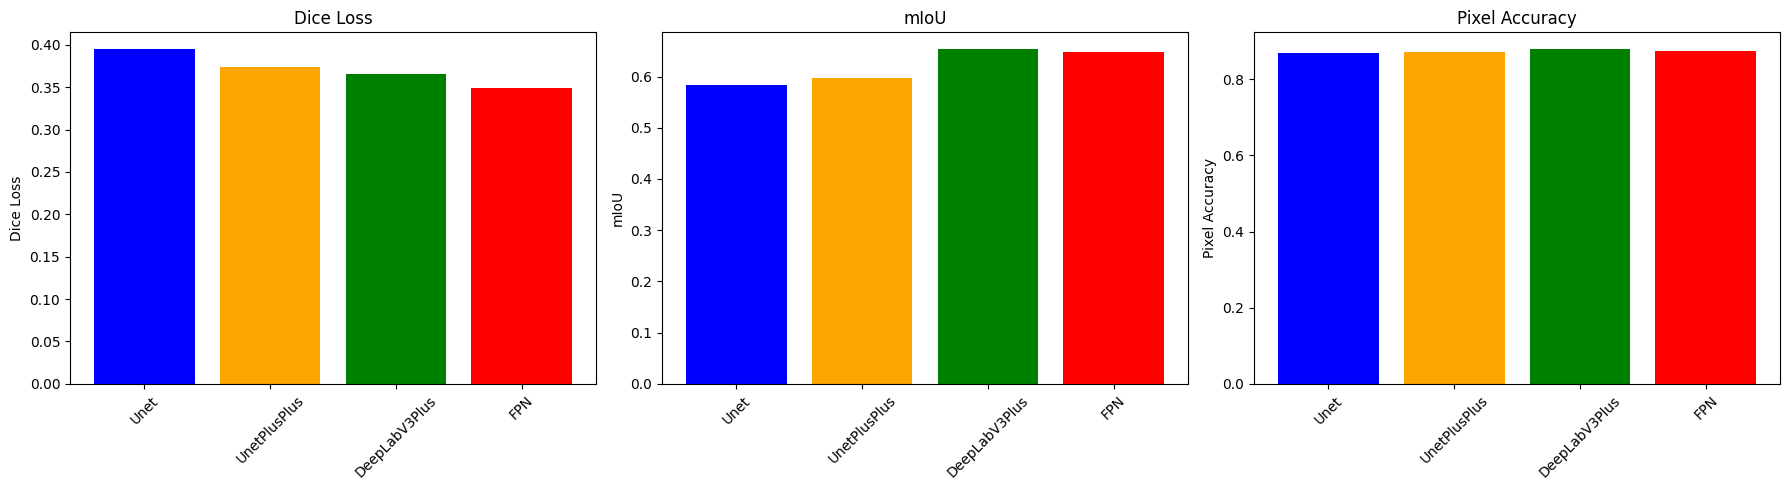

In [30]:
def compare_models(models, val_loader, device):
    """Evaluate multiple models and plot performance comparison."""
    results = []
    
    for model_name, model_path in models.items():
        metrics = evaluate_model(model_name, model_path, val_loader, device)
        results.append(metrics)
    
    # Convert results to a dictionary for plotting
    metrics_dict = {metric: [res[metric] for res in results] for metric in ["Model", "Dice Loss", "mIoU", "Pixel Accuracy"]}
    
    # Plot results
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    
    for i, metric in enumerate(["Dice Loss", "mIoU", "Pixel Accuracy"]):
        ax[i].bar(metrics_dict["Model"], metrics_dict[metric], color=['blue', 'orange', 'green', 'red'])
        ax[i].set_title(metric)
        ax[i].set_ylabel(metric)
        ax[i].set_xticklabels(metrics_dict["Model"], rotation=45)
    
    plt.tight_layout()
    plt.show()

# Run comparison
compare_models(models, val_loader, device)